In [31]:
import pandas as pd
import os
import numpy as np
import joblib
from scipy.stats import mode
from sklearn.model_selection import KFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from scipy.stats import mode


In [32]:
parent_path = '/home/modar/Desktop/AI_github_chatbot/Syrian-Heritage-Website/Q&A_data/'
rag_path = 'need_rag_refined/'
no_rag_path = 'no_need_rag/'

In [33]:
rag_data = [pd.read_csv(parent_path + rag_path + file) for file in os.listdir(parent_path+rag_path)]
no_rag_data = [pd.read_csv(parent_path + no_rag_path + file) for file in os.listdir(parent_path+no_rag_path)]

In [34]:
rag_csv = pd.concat(rag_data,ignore_index=True).drop_duplicates()#.drop(['Unnamed: 0'],axis=1).iloc[30:]
no_rag_csv = pd.concat(no_rag_data,ignore_index=True).drop(['Unnamed: 0'],axis=1).drop_duplicates()

In [35]:
len(rag_csv) , len(no_rag_csv.drop_duplicates())

(4137, 2162)

In [36]:
len(no_rag_csv) , len(no_rag_csv.drop_duplicates())

(2162, 2162)

In [37]:
combined_data_set = pd.concat([rag_csv,no_rag_csv],ignore_index=True).drop_duplicates()

In [38]:
len(combined_data_set)

6299

In [39]:
indices = combined_data_set['label'] != 'rag'
len(combined_data_set[indices]) , len(combined_data_set[~indices])

(2263, 4036)

In [40]:
import re
import spacy
from nltk.corpus import stopwords

nlp = spacy.load("en_core_web_sm")

custom_stopwords = set(stopwords.words("english")) - {"who", "what", "where", "when", "why", "how"}

def preprocess_text(text):
    """Clean and lemmatize text properly for history/culture."""
    text = text.lower()  
    text = re.sub(r"[^a-z\s]", "", text) 
    doc = nlp(text)
    
    tokens = [token.lemma_ for token in doc if token.text not in custom_stopwords and len(token.text) > 2]
    
    return " ".join(tokens)

combined_data_set["clean_question"] = combined_data_set["question"].apply(preprocess_text)
combined_data_set["encoded_label"] = [1 if label == 'rag' else 0 for label in combined_data_set['label']]

In [41]:
dict_ = {1:'rag',0:'no_rag'}

In [42]:
combined_data_set.head(10)

,question,label,Unnamed: 0,label,clean_question,encoded_label
0,Tell me about the significant event that took ...,rag,NaN,NaN,tell significant event take place involve abba...,1
1,Can you explain who succeeded Hariin after his...,rag,NaN,NaN,explain who succeed hariin assassination what ...,1
2,What happened to the male members of the Tulan...,rag,NaN,NaN,what happen male member tulanid house abbasid ...,1
3,I'm curious about the symbol used by the last ...,rag,NaN,NaN,curious symbol use last sufyani record when un...,1
4,"Wow, could you tell me more about the outcome ...",rag,NaN,NaN,wow could tell outcome last sufyani capture sy...,1
5,Give me details on what happened to the Tulani...,rag,NaN,NaN,give detail what happen tulanid capital alqata...,1
6,"Do you have any insights on who Shayban was, a...",rag,NaN,NaN,insight who shayban what role play event follo...,1
7,Can you explain the significance of the white ...,rag,NaN,NaN,explain significance white flag context sufyan...,1
8,How would you describe the impact of the Abbas...,rag,NaN,NaN,how would describe impact abbasid campaign fol...,1
9,Tell me about the consequence for the remainin...,rag,NaN,NaN,tell consequence remain male member tulanid ho...,1


In [43]:

save_path = '/home/modar/Desktop/AI_chatbot/intent_classifier_models/'
combined_data_set = combined_data_set.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    combined_data_set['clean_question'], 
    combined_data_set['encoded_label'], 
    test_size=0.3, 
    random_state=42, 
    stratify=combined_data_set['encoded_label']
)

vectorizer = TfidfVectorizer(
    max_features=1000,  
    ngram_range=(1, 2),  
    stop_words=list(custom_stopwords)
)

X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

joblib.dump(vectorizer, "vectorizer.pkl")

kf = KFold(n_splits=5, shuffle=True, random_state=42)

clf_name = 'svc'
models_path = []
fold = 1

for train_index, val_index in kf.split(X_train):
    print(f"\nTraining Fold {fold}...")
    
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    if clf_name.lower() == 'random forest':
        clf = RandomForestClassifier(n_estimators=200, max_depth=25, min_samples_split=5, 
                                     random_state=42, class_weight="balanced")
    else:
        clf = SVC(kernel="linear", C=0.7, class_weight="balanced", random_state=42)

    clf.fit(X_train_fold, y_train_fold)
    
    model_filename = f"model_fold_{fold}.pkl"
    joblib.dump(clf, save_path + model_filename)
    models_path.append(save_path + model_filename)
    
    y_val_pred = clf.predict(X_val_fold)
    print(f"Fold {fold} Classification Report:\n")
    print(classification_report(y_val_fold, y_val_pred))

    fold += 1

print("\nAll models trained and saved.\n")

print("Evaluating on the test set...\n")

models = []
for path in models_path:
    models.append(joblib.load(path))
preds = []
for model in models: 
    preds.append(model.predict(X_test))
preds = np.array(preds)
preds = np.array(mode(preds,axis=0)[0])
print(classification_report(preds, y_test))


Training Fold 1...
Fold 1 Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       308
           1       0.97      0.98      0.98       574

    accuracy                           0.97       882
   macro avg       0.97      0.96      0.97       882
weighted avg       0.97      0.97      0.97       882


Training Fold 2...
Fold 2 Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       319
           1       0.97      0.99      0.98       563

    accuracy                           0.98       882
   macro avg       0.98      0.97      0.98       882
weighted avg       0.98      0.98      0.98       882


Training Fold 3...
Fold 3 Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       301
           1       0.98      1.00      0.99       581

    accuracy                 

Plotting decision function confidence...


/home/modar/myenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/modar/myenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


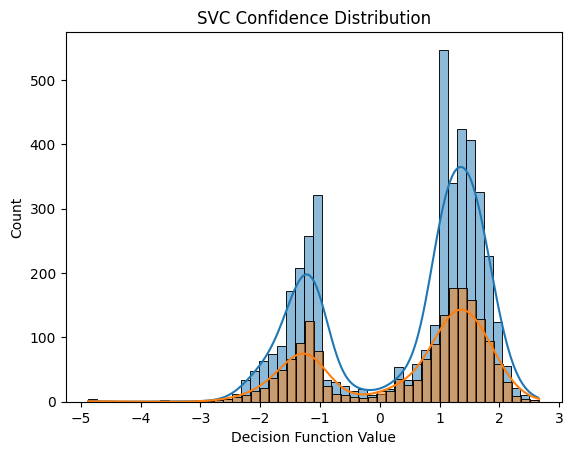

In [16]:
print("Plotting decision function confidence...")
decision_function = models[0].decision_function(X_train)  
sns.histplot(decision_function, bins=50, kde=True)
plt.xlabel("Decision Function Value")
plt.title("SVC Confidence Distribution")
decision_function = models[0].decision_function(X_test)  
sns.histplot(decision_function, bins=50, kde=True)
plt.xlabel("Decision Function Value")
plt.title("SVC Confidence Distribution")
plt.show()

In [17]:
new_questions = [
    'Marhaba',
    'Hello Habibi',
    'Tell me about the roman invasion in syria and lebanon, and what economical effects did it have',
    'Tell me joke about syria',
    'I am curuious about El eskandar wars in Syria',
    'What are the obstacels when using the hisotry'
]
models = [joblib.load(path) for path in models_path]

new_questions_cleaned = [preprocess_text(question) for question in new_questions]
new_questions_vectorized = vectorizer.transform(new_questions_cleaned)

preds = np.array([model.predict(new_questions_vectorized) for model in models])

final_preds = np.array(mode(preds, axis=0)[0]).flatten()
final_preds = [dict_[pred] for pred in final_preds]
distances = []
for i in range(len(new_questions)):
    res = 0.0
    for model in models:
        res += model.decision_function(new_questions_vectorized[i]) 
    distances.append(res/5.0)
data_frame = pd.DataFrame({'question':new_questions,'predicted_value':final_preds,'distances':distances})
data_frame


,question,predicted_value,distances
0,Marhaba,rag,[0.3035764926575544]
1,Hello Habibi,rag,[0.3035764926575544]
2,Tell me about the roman invasion in syria and ...,rag,[0.21967256577755084]
3,Tell me joke about syria,no_rag,[-1.7681427606594506]
4,I am curuious about El eskandar wars in Syria,no_rag,[-1.7709150360150532]
5,What are the obstacels when using the hisotry,rag,[0.8511136267259355]


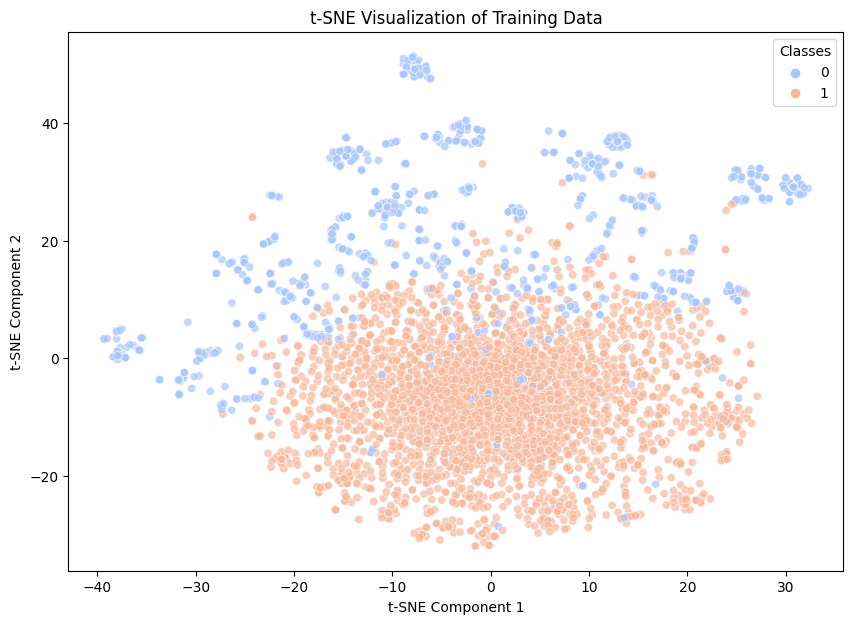

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50, random_state=42, learning_rate=200)
X_tsne = tsne.fit_transform(X_train.toarray())  

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=np.array(y_train), palette="coolwarm", alpha=0.7)
plt.title("t-SNE Visualization of Training Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Classes")
plt.show()

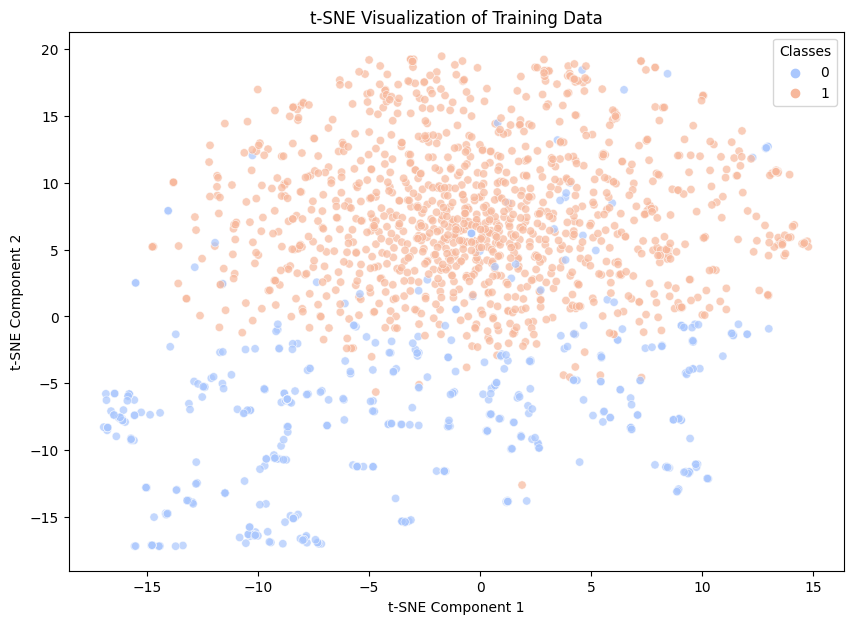

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50, random_state=42, learning_rate=200)
X_tsne = tsne.fit_transform(X_test.toarray())  

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=np.array(y_test), palette="coolwarm", alpha=0.7)
plt.title("t-SNE Visualization of Training Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Classes")
plt.show()


In [20]:
###############################################################3
###################################################
###############################################################3
###################################################
###############################################################3
###################################################
##    NEWENWENWENWNE MODEL
###############################################################3
##################################################################################################################3
##################################################################################################################3
##################################################################################################################3
##################################################################################################################3
###################################################

In [21]:
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('all-MiniLM-L6-v2')

Batches:   0%|          | 0/134 [00:00<?, ?it/s]

Batches:   0%|          | 0/58 [00:00<?, ?it/s]

In [45]:
X_train = embedder.encode(X_train_raw.tolist(), batch_size=32, show_progress_bar=True)
X_test = embedder.encode(X_test_raw.tolist(), batch_size=32, show_progress_bar=True)

Batches:   0%|          | 0/138 [00:00<?, ?it/s]

Batches:   0%|          | 0/60 [00:00<?, ?it/s]

In [47]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)
joblib.dump(clf, "intent_classifier.pkl")

['intent_classifier.pkl']

In [60]:
import re
from sentence_transformers import SentenceTransformer
import joblib
import time 

embedder = SentenceTransformer('all-MiniLM-L6-v2')
clf = joblib.load("intent_classifier.pkl")

def classify_intent(query):
    query_lower = query.lower()
    if re.search(r"\b(hello|marhaba|hi|good|thank|joke|poem|fun|Keefak|peace upon you|Morning|Evening)\b", query_lower):
        return "no_rag"
    #if re.search(r"\b(what|when|where|who|how|why|\d{3,4}|roman|invasion|wars)\b|\?$", query_lower):
    #    return "rag"
    query_embedding = embedder.encode([query])[0]
    pred = clf.predict([query_embedding])[0]
    return "rag" if pred == 1 else "no_rag"


In [75]:
# Assuming classify_intent is defined (e.g., SVC, hybrid, or LLM-based)
new_questions = [
    "Marhaba, how’s it going?",
    "Hello Habibi, what’s up?",
    "Hi there, good morning!",
    "Tell me a joke about Syria.",
    "What’s your favorite Syrian dish?",
    "Write a short poem about Damascus.",
    "What do you think about Syrian music?",
    "What’s something cool about Syrian culture?",
    "Tell me a fun fact about Syria.",
    "How would you describe Syrian hospitality?",
    "What did Trajan do in Syria in 114?",
    "Who ruled Aleppo during the Abbasid period?",
    "What were the economic effects of the Roman invasion in Syria?",
    "How did the Umayyad Mosque influence Syrian architecture?",
    "What happened during Alexander the Great’s wars in Syria?",
    "What obstacles did historians face when documenting Syrian history?",
    "Tell me about Syria.",
    "What’s the history of Syria like?",
    "Hey, what’s interesting about Syrian heritage?",
    "Hi, can you tell me a story about ancient Syria?",
    "What can be learned about the social structure of ancient city-states from their leadership hierarchy, and what were the key characteristics?",
"How did the roles of kings, officials, and elders reflect the social hierarchy of their time, and what were the implications?",
"What insights do ancient tablets provide into the daily life and governance of early city-states, and what can be learned from them?",
"What might have been the reasons behind a resurgent Assyria posing a threat to Saushtatar?",
"How did Saushtatar's strategic advantage of ignoring Hatti as an ally of Egypt contribute to his overall strategy?",
"How did the internal issues within Hatti's kingdom influence Saushtatar's decision-making?",
"What potential repercussions could arise from Assyria's resurgence in the region?",
"Can you tell me about Syrian architecture?",
"How did Syria get its independence?",
"What happened to Septimius Geta after his father's death?",
"According to historical texts, what is identified as the single most significant scientific work translated from Arabic into Latin during a specific historical period, and who is credited with its translation?"
]
total = 0.0
all_ = []
for q in new_questions:
    t = time.time()
    print(f"{q}: {classify_intent(q)}")
    all_.append(time.time() - t)
    total += all_[-1]
total = total / len(new_questions)

Marhaba, how’s it going?: no_rag
Hello Habibi, what’s up?: no_rag
Hi there, good morning!: no_rag
Tell me a joke about Syria.: no_rag
What’s your favorite Syrian dish?: no_rag
Write a short poem about Damascus.: no_rag
What do you think about Syrian music?: no_rag
What’s something cool about Syrian culture?: no_rag
Tell me a fun fact about Syria.: no_rag
How would you describe Syrian hospitality?: no_rag
What did Trajan do in Syria in 114?: rag
Who ruled Aleppo during the Abbasid period?: no_rag
What were the economic effects of the Roman invasion in Syria?: rag
How did the Umayyad Mosque influence Syrian architecture?: no_rag
What happened during Alexander the Great’s wars in Syria?: no_rag
What obstacles did historians face when documenting Syrian history?: rag
Tell me about Syria.: no_rag
What’s the history of Syria like?: no_rag
Hey, what’s interesting about Syrian heritage?: no_rag
Hi, can you tell me a story about ancient Syria?: no_rag
What can be learned about the social struct

In [2]:
import pandas as pd

# Data in the form of a list of tuples
data = [
    ("Marhaba, how’s it going?", "no_rag"),
    ("Hello Habibi, what’s up?", "no_rag"),
    ("Hi there, good morning!", "no_rag"),
    ("Tell me a joke about Syria.", "no_rag"),
    ("What’s your favorite Syrian dish?", "no_rag"),
    ("Write a short poem about Damascus.", "no_rag"),
    ("What do you think about Syrian music?", "no_rag"),
    ("What’s something cool about Syrian culture?", "no_rag"),
    ("Tell me a fun fact about Syria.", "no_rag"),
    ("How would you describe Syrian hospitality?", "no_rag"),
    ("What did Trajan do in Syria in 114?", "rag"),
    ("Who ruled Aleppo during the Abbasid period?", "no_rag"),
    ("What were the economic effects of the Roman invasion in Syria?", "rag"),
    ("How did the Umayyad Mosque influence Syrian architecture?", "no_rag"),
    ("What happened during Alexander the Great’s wars in Syria?", "no_rag"),
    ("What obstacles did historians face when documenting Syrian history?", "rag"),
    ("Tell me about Syria.", "no_rag"),
    ("What’s the history of Syria like?", "no_rag"),
    ("Hey, what’s interesting about Syrian heritage?", "no_rag"),
    ("Hi, can you tell me a story about ancient Syria?", "no_rag"),
    ("What can be learned about the social structure of ancient city-states from their leadership hierarchy, and what were the key characteristics?", "rag"),
    ("How did the roles of kings, officials, and elders reflect the social hierarchy of their time, and what were the implications?", "rag"),
    ("What insights do ancient tablets provide into the daily life and governance of early city-states, and what can be learned from them?", "rag"),
    ("What might have been the reasons behind a resurgent Assyria posing a threat to Saushtatar?", "rag"),
    ("How did Saushtatar's strategic advantage of ignoring Hatti as an ally of Egypt contribute to his overall strategy?", "rag"),
    ("How did the internal issues within Hatti's kingdom influence Saushtatar's decision-making?", "rag"),
    ("What potential repercussions could arise from Assyria's resurgence in the region?", "rag"),
    ("Can you tell me about Syrian architecture?", "no_rag"),
    ("How did Syria get its independence?", "no_rag"),
    ("What happened to Septimius Geta after his father's death?", "rag"),
    ("According to historical texts, what is identified as the single most significant scientific work translated from Arabic into Latin during a specific historical period, and who is credited with its translation?", "rag")
]

# Create a DataFrame
df = pd.DataFrame(data, columns=["Question", "Category"])

# Display the DataFrame
df

,Question,Category
0,"Marhaba, how’s it going?",no_rag
1,"Hello Habibi, what’s up?",no_rag
2,"Hi there, good morning!",no_rag
3,Tell me a joke about Syria.,no_rag
4,What’s your favorite Syrian dish?,no_rag
5,Write a short poem about Damascus.,no_rag
6,What do you think about Syrian music?,no_rag
7,What’s something cool about Syrian culture?,no_rag
8,Tell me a fun fact about Syria.,no_rag
9,How would you describe Syrian hospitality?,no_rag


In [63]:
from langchain_groq import ChatGroq  # type: ignore #*********************************************************************

os.environ['GROQ_API_KEY']  =  "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"
classifier_name = 'qwen-2.5-32b'

intent_classifier_model = ChatGroq(model_name=classifier_name, temperature=0)


In [65]:
import operator
from config import config
import os
from langchain_community.embeddings import HuggingFaceEmbeddings
from utils import bcolors, get_tavily_search , get_duckduckgo_search, get_res
from langgraph.graph import MessagesState # type: ignore
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage # type: ignore
from nodes import GraderNode , GenerationNode
from langchain_groq import ChatGroq  # type: ignore #*********************************************************************
from dotenv import load_dotenv # type: ignore
from langchain.schema import Document  
import numpy as np
import pickle
from typing import Annotated, Literal
from pydantic import BaseModel, Field # type: ignore
import faiss

class ClassifyQuery(BaseModel):
    """Binary score for intent classification."""
    binary_score: Literal["yes", "no"] = Field(
        description="User query intent needs to use RAG or not, 'yes' or 'no'"
    )

In [71]:
intent_classifier_model = ChatGroq(model_name=classifier_name, temperature=0)
intent_classifier_model = intent_classifier_model.with_structured_output(ClassifyQuery)

class State(MessagesState):
    summary: str
    tavily_docs: str
    duckduck_docs: str
    documents: list
    question: str
    generation: str

def intent_classifier(question):
 
    rag_prompt = f'''You received the following query: "{question}". Determine if this query requires retrieving historical or cultural information from the database.

    - Answer "yes" if the query asks for detailed historical or cultural data.
    - Answer "no" if the query is casual, general, or does not require such data (e.g., greetings, jokes, or simple facts).

    Examples that should return "no":
    - What is the capital of Syria?
    - Hello.
    - Tell me a joke about Syria.
    - What is a delicious dish in Syria?

    Examples that should return "yes":
    - What cultural significance did wine hold in the ancient Near East, and how did it impact the daily lives of people in the region?
    - What was the total number of locations in the region after the additions during the Greco-Roman period?
    - How did the sultan's punitive expedition affect the villages in the region where the robbery took place?

    Return only a binary score "yes" or "no" with no additional text.'''
    response = intent_classifier_model.invoke([SystemMessage(content=rag_prompt)])
    no_rag = False
    
    if response.binary_score.lower() == 'yes':
        no_rag = False
    else:
        no_rag = True
    return {'question': question , 'messages': question, 'no_rag': no_rag}


In [72]:
intent_classifier('Hello')

{'question': 'Hello', 'messages': 'Hello', 'no_rag': True}

In [78]:
total_llm = 0.0
all_llm = []
for q in new_questions:
    t = time.time()
    print(f"{q}: {intent_classifier(q)}")
    all_llm.append(time.time() - t)
    total_llm += all_llm[-1]
total_llm = total_llm / len(new_questions)

Marhaba, how’s it going?: {'question': 'Marhaba, how’s it going?', 'messages': 'Marhaba, how’s it going?', 'no_rag': True}
Hello Habibi, what’s up?: {'question': 'Hello Habibi, what’s up?', 'messages': 'Hello Habibi, what’s up?', 'no_rag': True}
Hi there, good morning!: {'question': 'Hi there, good morning!', 'messages': 'Hi there, good morning!', 'no_rag': True}
Tell me a joke about Syria.: {'question': 'Tell me a joke about Syria.', 'messages': 'Tell me a joke about Syria.', 'no_rag': True}
What’s your favorite Syrian dish?: {'question': 'What’s your favorite Syrian dish?', 'messages': 'What’s your favorite Syrian dish?', 'no_rag': True}
Write a short poem about Damascus.: {'question': 'Write a short poem about Damascus.', 'messages': 'Write a short poem about Damascus.', 'no_rag': False}
What do you think about Syrian music?: {'question': 'What do you think about Syrian music?', 'messages': 'What do you think about Syrian music?', 'no_rag': False}
What’s something cool about Syrian 

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

/home/modar/myenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

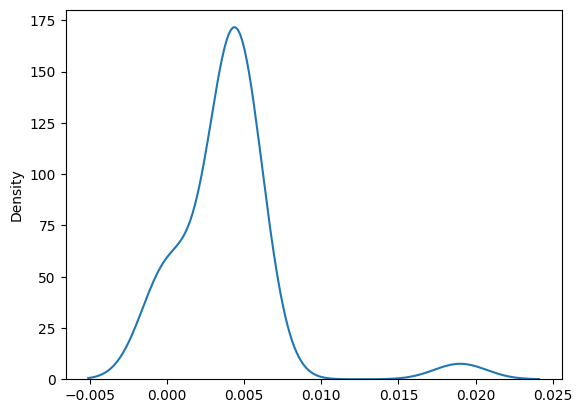

In [83]:
sns.kdeplot(all_)

/home/modar/myenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

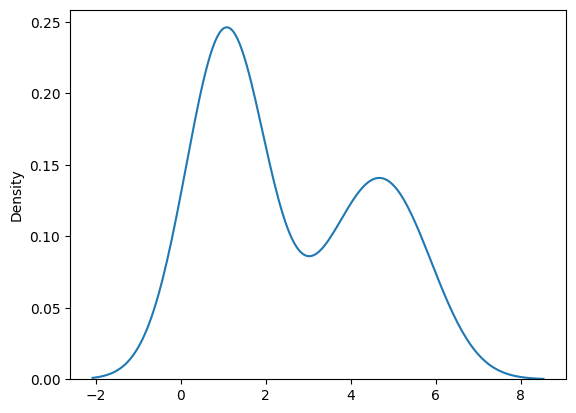

In [84]:
sns.kdeplot(all_llm)

In [86]:
total , total_llm

(0.003913018011277722, 2.562478288527458)